# CMSC828O - Jason Fan - HW2, Questions 1 and 2

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import scipy

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt

# Preamble

The GIs used in this notebook are parsed with R code taken *verbatim* from https://www.hcbravo.org/networks-across-scales/homeworks/network_stats/

In [2]:
gis_path = 'data/output/costanzo_gis_adj.tsv'
gis_df = pd.read_csv(gis_path, sep='\t')
gis_df.index = gis_df.columns
gis_df.head()

,dma3986,dma969,dma2913,dma2871,dma86,dma2378,dma955,dma2338,dma272,dma2549,...,dma4417,dma3050,dma1905,dma1565,dma5343,dma3023,dma4495,dma796,dma2289,dma1373
dma3986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dma969,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dma2913,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dma2871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dma86,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
gis_df.shape

(2803, 2803)

In [4]:
A = gis_df.values

# Question 1: 
**Q:** Is this degree distribution consistent with a network generated by the Erdös-Renyi network model? Why?

**A:** No, the GI network is not generated by the Erdos Renyi model (ER). As shown by the plot below, which plots a binomial degree distribution (with <k> derived from the mean degree of the GI network), the GI network has many more nodes of high degree. The ER model does not have hubs.

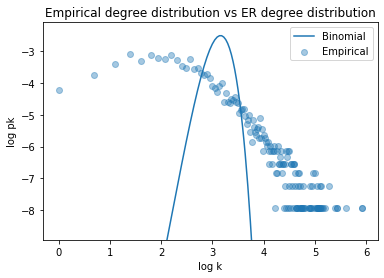

In [5]:
def empirical_deg_dist(A, kmin=0, include_le_kmin=False):
    '''
    For plotting purposes, \sum(P(k=K)) = 1 forall k >= kmin
    NB: this lets us plot the power law fitted lines through the data since only
    only nodes of degree >= kmin are modelled
    '''
    degrees = np.sum(A, axis=0)
    if not include_le_kmin:
        degrees = degrees[degrees >= kmin]
    k, pk = np.unique(degrees, return_counts=True)
    pk = pk / np.sum(pk[k>= kmin])
    return k, pk

def fit_and_plot_binom(A):
    k, pk = empirical_deg_dist(A)
    
    not_0 = k>0
    k = k[not_0]
    pk = pk[not_0]
    
    log_pk = np.log(pk)
    log_k = np.log(k)

    avg_deg = np.sum(pk.dot(k))
    n_nodes = len(A)
    p_edge = avg_deg / n_nodes

    rv = scipy.stats.binom(n_nodes-1, p_edge)
    binom_pk = [rv.pmf(x) for x in k]
    log_binom_pk = np.log(binom_pk)
    plt.scatter(log_k, log_pk,  label='Empirical',  alpha=0.4)
    plt.plot(log_k, log_binom_pk, label='Binomial')
    plt.ylim((min(log_pk)-1, max(log_pk) + 1),)
    plt.legend()
    plt.xlabel('log k')
    plt.ylabel('log pk')
    plt.title('Empirical degree distribution vs ER degree distribution')
fit_and_plot_binom(A)

# Question 2

Here we first show that we can estimate $\gamma$

In [6]:
def gamma_at_kmin(kmin, degs):
    '''
    estimates gamma of power law given degrees
    NOTE: sums should be taken from kmin to kmax
    '''
    d = degs[degs >= kmin] # Take log probs w.r.t only samples generated by powerlaw
    N = len(d)
    return 1 + N / np.sum( np.log(d / (kmin - 0.5)) )

def fit_power_law_pmf(kmin, degs):
    gamma = gamma_at_kmin(kmin, degs)
    def pmf(k):
        return k ** (-gamma) / scipy.special.zeta(gamma, kmin)
    return pmf

By inspection, we "guess" $K_{min}$ to be 12, and sanity check that our procedure works.

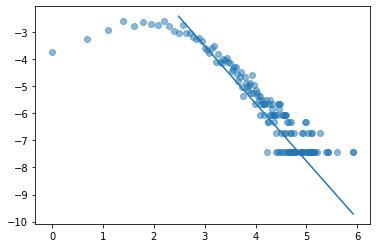

In [7]:
# Sanity check to see that the procdure works and that we can plot a predicted linear 
# (in log-log) relationship with fitted gamma for some kmin
kmin=12
ks, pks = empirical_deg_dist(A, kmin=kmin, include_le_kmin=True)
flags = ks > 0
ks, pks = ks[flags], pks[flags]

degs = np.sum(A, axis=0)
pmf = fit_power_law_pmf(kmin, degs)
power_pks = [pmf(k) for k in ks if k>=kmin]
plt.plot(np.log(ks[ks >=kmin]), np.log(power_pks))
plt.scatter(np.log(ks), np.log(pks), alpha=0.5)

In [8]:
'''
Some helper functions to find the 'right' $\gamma$
'''

def fit_power_law_cdf(kmin, degs):
    gamma = gamma_at_kmin(kmin, degs)
    def cdf(k):
        return 1 - (scipy.special.zeta(gamma, k) / scipy.special.zeta(gamma, kmin))
    return cdf

def _empirical_cdf(A, kmin=None):
    ks, pks = empirical_deg_dist(A, kmin=kmin)
    max_deg = max(ks)
    filled_cumsum = [np.sum(pks[ks <= k]) for k in range(max_deg + 1)]
    filled_ks = np.arange(max_deg + 1)
    return filled_ks, filled_cumsum

def empirical_cdf(A, kmin=None):
    ks, cumsum = _empirical_cdf(A, kmin=kmin)
    def cdf(k):
        return cumsum[k]
    return cdf

def D(A, kmin):
    kmax = np.max(np.sum(A, axis=0))
    pl_cdf =  fit_power_law_cdf(kmin, np.sum(A, axis=0))
    e_cdf = empirical_cdf(A, kmin)
    errs = [np.abs(e_cdf(k) - pl_cdf(k)) for k in range(kmin, kmax + 1)]
    return np.max(errs)    

Let's plot the CDFs and divergences at different $k_{min}$

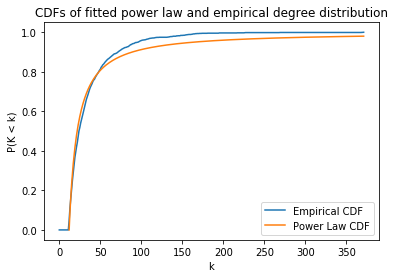

In [9]:
# Visualizing the PDFs

degs = np.sum(A, axis=0)
max_deg = np.max(degs)
ks = np.arange(max_deg + 1)
e_cdf = empirical_cdf(A, kmin)
pl_cdf = fit_power_law_cdf(kmin, degs)

plt.plot(ks, [e_cdf(k) for k in ks], label='Empirical CDF')
plt.plot(ks[ks>=kmin], [pl_cdf(k) for k in ks if k>=kmin], label='Power Law CDF')
plt.title('CDFs of fitted power law and empirical degree distribution')
plt.xlabel('k')
plt.ylabel('P(K < k)')
_ = plt.legend()

Let's calculate and plot the divergences for different $k_{min}$, (like *image* 4.24(b))

In [10]:
Ds = [D(A, k) for k in range(1, max_deg+1)]

/home/jason/miniconda3/envs/CMSC828O/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


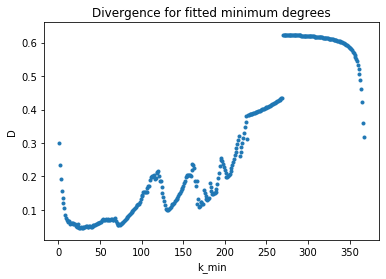

In [11]:
plt.scatter(np.arange(1, len(Ds) + 1), Ds, marker='.')
plt.title('Divergence for fitted minimum degrees')
plt.xlabel('k_min')
_ = plt.ylabel('D')

Now we retrieve $k_{min}$ and respective ${\gamma}$

In [12]:
kmin = np.arange(1, max_deg + 1)[np.nanargmin(Ds)]

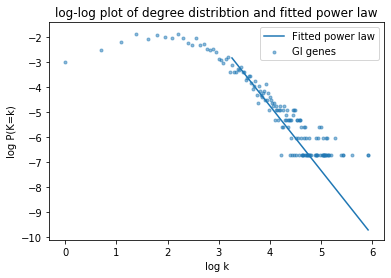

In [13]:
ks, pks = empirical_deg_dist(A, kmin=kmin, include_le_kmin=True)
flags = ks > 0
ks, pks = ks[flags], pks[flags]

degs = np.sum(A, axis=0)
pmf = fit_power_law_pmf(kmin, degs)
power_pks = [pmf(k) for k in ks if k>=kmin]
plt.plot(np.log(ks[ks >=kmin]), np.log(power_pks), label='Fitted power law')
plt.scatter(np.log(ks), np.log(pks), alpha=0.5, marker='.', label='GI genes')
plt.title('log-log plot of degree distribtion and fitted power law')
plt.xlabel('log k')
plt.ylabel('log P(K=k)')
_= plt.legend()

**Answer to 2**

In [14]:
print("Gamma:", gamma_at_kmin(kmin, degs))

Gamma: 2.585782917761267


In [15]:
print("k_min:", kmin)

k_min: 26
